# 用于生成所有地块内规划路径和仿真路径的结果

In [1]:
import pandas as pd 
from CPP_Planner import CPP_Planner_Kit, CPP_Algorithms, CPP_Algorithm_Optimizers, CPP_Planner_TurningRail_Maker
import matplotlib.pyplot as plt
from shapely import Point, LineString
import geopandas as gpd
import datetime
import matplotlib
import warnings
import rasterio
from enum import Enum
import numpy as np


In [2]:
all_land = CPP_Planner_Kit.load_fields('../Scratch/test_Load_Shp/shp_file/村地和道路/村地地块区域.shp')
all_land = all_land.drop(index=1)
warnings.filterwarnings('ignore')
mean_slope = [3.37, 7.38, 6.07, 3.94, 6.53, 7.46, 7.62]
matplotlib.rcParams['font.sans-serif'] = ['PingFang HK']

def get_all_land_with_min_headland_edge(swath_width, head_land_width=6):
    # 通过计算最小边来获得路径
    # all_land = CPP_Planner_Kit.load_fields('Scratch/test_Load_Shp/shp_file/村1地_全区.shp')
    turning_radius = 4.5
    vehicle_length = 6.3
    vehicle_width = 1.9
    head_land_width = 0
    headland_width, vehicle_theta = CPP_Planner_Kit.calc_headland_width(turning_radius, swath_width, vehicle_length,
                                                                        vehicle_width,
                                                                        buffer=0.3, show_info=True)

    num_land = len(all_land)
    print("田块的个数: ", num_land)

    all_land_path = []
    all_headland = []
    all_headland_move = []
    all_turning_curves = []
    all_backward_moves = []
    all_forward_moves = []
    for index in range(num_land):
        print("Land no: ", index + 1)
        slope = mean_slope[index]
        temp_corrected_swath_length = CPP_Planner_Kit.get_corrected_swath_width(swath_width, slope)
        single_land = CPP_Planner_Kit.get_single_shp(all_land, index)
        # 分割田块为简单的多边形
        split_polygon = CPP_Planner_Kit.split_polygon_by_largest_area(single_land.geometry.iloc[0], tolerance=0.03)
        # 对分割的每一个多边形进行路径规划，这一次使用的是从多边形的每一边开始顺着边开始计算路径，找到各边中地头占据面积最小的区域
        for polygon in split_polygon:
            if polygon.area > 20:
                # 计算当前多边形的每一条边，顺着进行路径规划，找到地头占据面积最小的那一条边
                polygon_regen = gpd.GeoDataFrame(geometry=[polygon], crs=all_land.crs)
                polygon_centroid = polygon_regen.centroid[0]
                # TODO: 检查 theta 是否正确
                temp_path, temp_headland, theta = CPP_Algorithm_Optimizers.gen_path_with_minimum_headland_area_by_edge(
                    land=polygon_regen, step_size=temp_corrected_swath_length, head_land_width=headland_width,
                    headland_mode='right', compare_mode='headland', return_theta=True
                )
                print(theta)
                # 计算地头的转向等路径
                forward_moves, turning_curves, backward_moves = CPP_Planner_TurningRail_Maker.gen_S_turning_paths_in_polygon(
                    temp_path, theta, turning_radius, vehicle_length, vehicle_width, swath_width, headland_width,
                    polygon_centroid, 0.1
                )

                all_headland_move.append(forward_moves)
                all_turning_curves.append(turning_curves)
                all_forward_moves.append(forward_moves)
                all_backward_moves.append(backward_moves)
                all_land_path.append(temp_path)
                # all_land_lines += temp_path.geometry
                all_headland.append(temp_headland)

    # plt.show()
    temp_land_paths = [all_land_path[x] for x in [0, 1, 4, 5, 6, 7, 8]]
    temp_turnings = [all_turning_curves[x] for x in [0, 1, 4, 5, 6, 7, 8]]
    temp_backward_moves = [all_backward_moves[x] for x in [0, 1, 4, 5, 6, 7, 8]]
    temp_forward_moves = [all_forward_moves[x] for x in [0, 1, 4, 5, 6, 7, 8]]
    # return temp_land_paths, temp_turnings, temp_backward_moves, temp_forward_moves
    return all_land_path,  all_turning_curves, all_backward_moves, all_forward_moves

land_paths, turnings, backward_moves, forward_moves = get_all_land_with_min_headland_edge(1.45)

总地块数 7
Theta:  0.6682897949014295
r2:  6.294839156007086
Theta2:  0.5240721827749459
w2: 5.849442958825377
Buffer:  0.3
最终地头宽度:  9.299442958825377
田块的个数:  6
Land no:  1
split_polygon_by_largest_area： 开始进行田块分割，当前误差范围 tolerance = 0.03
Num of convex_hull:  9
Num of Polygon lines:  14
Not on Convex:  6
119.10064699085248
-62.949402993016655
-61.05889360496882
Land no:  2
split_polygon_by_largest_area： 开始进行田块分割，当前误差范围 tolerance = 0.03
Num of convex_hull:  7
Num of Polygon lines:  11
Not on Convex:  7
-77.16041339661301
88.44131293710659
Land no:  3
split_polygon_by_largest_area： 开始进行田块分割，当前误差范围 tolerance = 0.03
Num of convex_hull:  9
Num of Polygon lines:  13
Not on Convex:  6
Num of convex_hull:  7
Num of Polygon lines:  9
Not on Convex:  4
Num of convex_hull:  6
Num of Polygon lines:  7
Not on Convex:  2
-98.23125830827709
82.79939614136123
83.02133270567711
83.02133270573958
Land no:  4
split_polygon_by_largest_area： 开始进行田块分割，当前误差范围 tolerance = 0.03
-82.13416409694425
Land no:  5
split_p

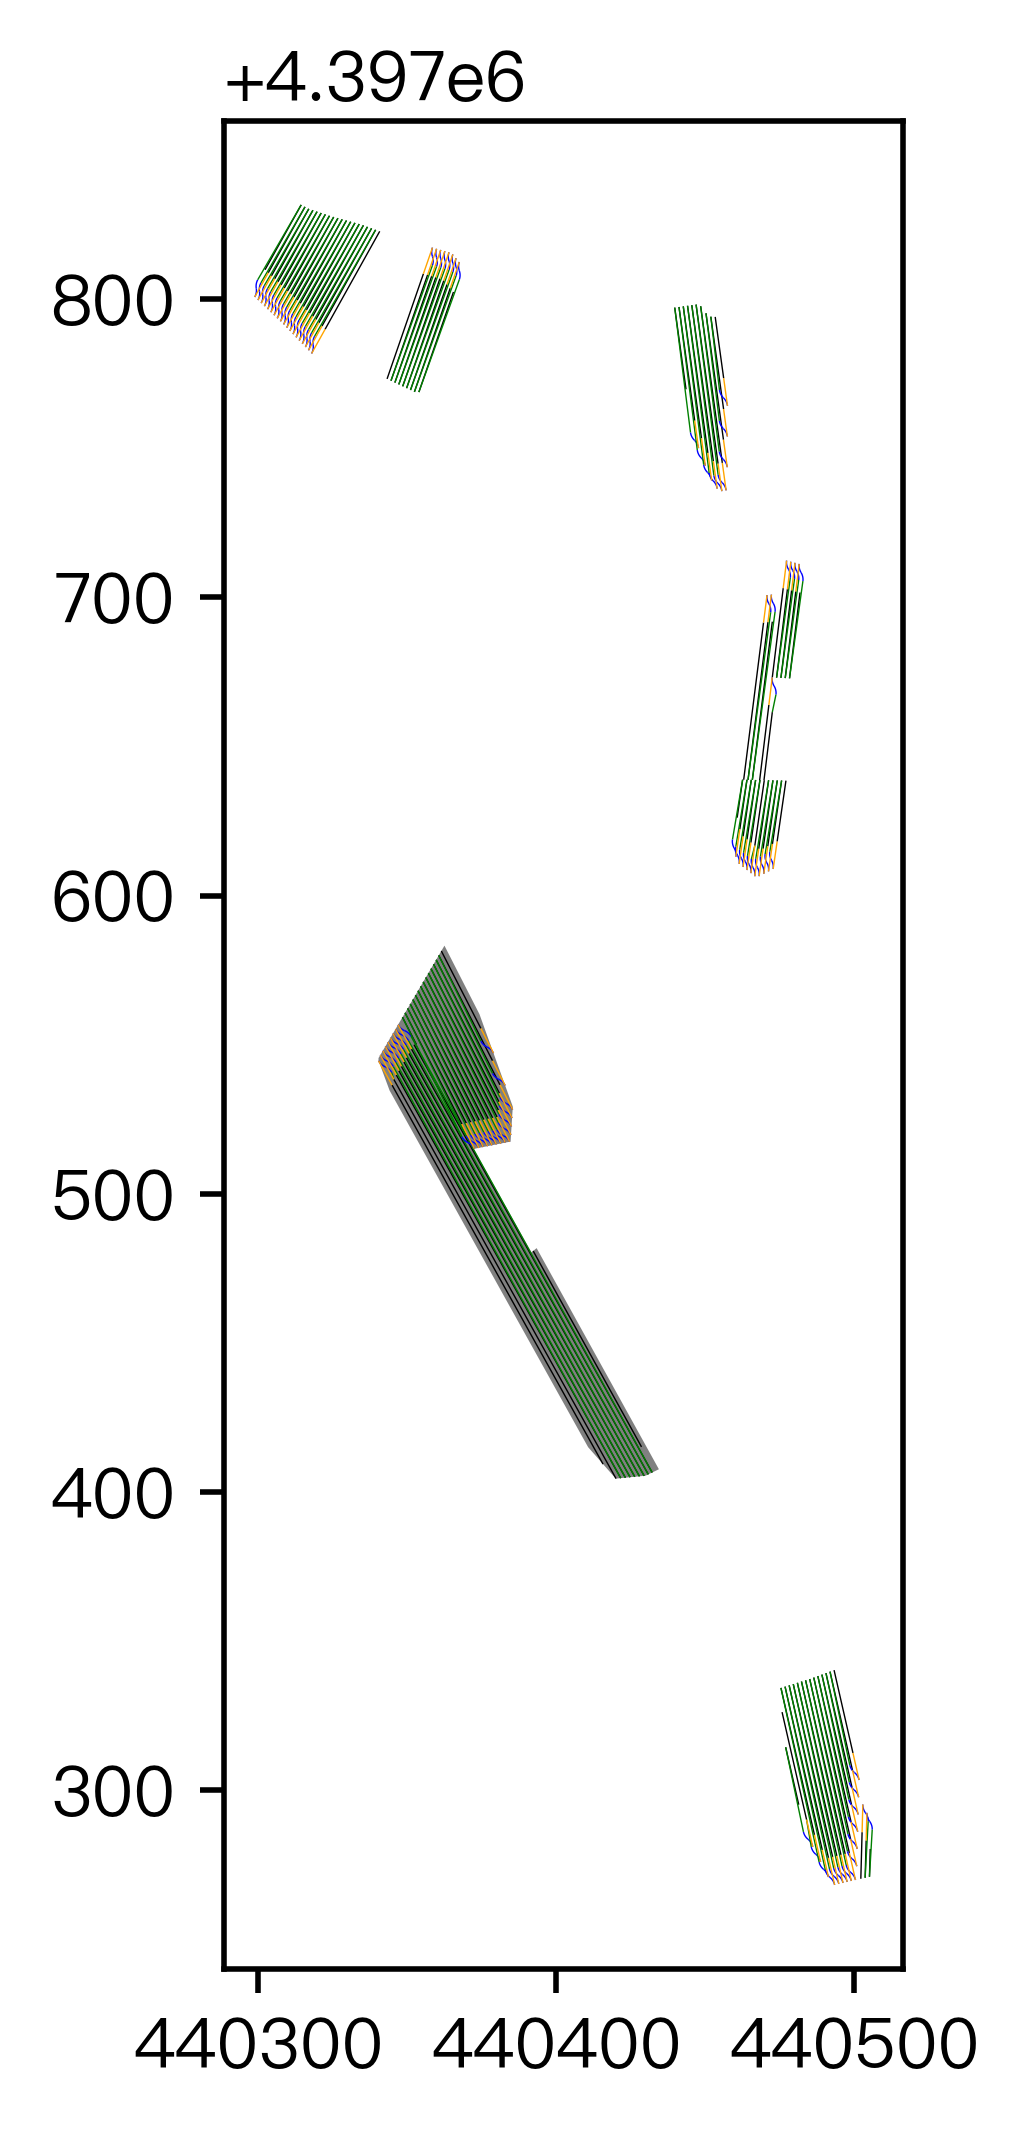

In [3]:
_, ax = plt.subplots(dpi=500)
# all_land.plot(ax=ax)
CPP_Planner_Kit.get_single_shp(all_land, 0).plot(ax=ax, color='gray')
ax.set_aspect('equal')
count = 0
for land, turning, backward, forward in zip(land_paths, turnings, backward_moves, forward_moves):
    land.plot(ax=ax, color='black', linewidth=0.2)
    turning.plot(ax=ax, color='blue', linewidth=0.2)
    backward.plot(ax=ax, color='green', linewidth=0.2)
    forward.plot(ax=ax, color='orange', linewidth=0.2)
    # if count >= 1:
    #     break
    # count += 1
    

# 完成了路径规划后，应该做仿真规划

In [4]:
swath_sep_indxes = [0, 28, 39, 49, 71]
useful_land_indexes = [0, 4, 5, 6]
# 一些农机数据
vehicle_weight = 1980 + 342.5  # 拖拉机 + 耕作机械 重量（kg）
vehicle_wheel_width = 1440  # 农机轮距（mm）

opti_path = '../PSO_APF_analysis/opt16/pso_result.csv'
real_swath_path = r'GIS_data/路径规划优化用数据/all_swaths/all_swaths_group.shp'
straight_swath_path_2 = r'GIS_data/路径规划优化用数据/all_swaths/straight_swaths_1_new.shp'
straight_swath_path = r'GIS_data/路径规划优化用数据/all_swaths/all_straight_swaths_group.shp'

opti_parameters = pd.read_csv(opti_path)

with rasterio.open('GIS_data/路径规划优化用数据/Aspect_clip_pcGen_2m_21.tif') as aspect_src:
    aspect_array = aspect_src.read(1)
# with rasterio.open('GIS_data/路径规划优化用数据/Slope_clip_pcGen_2m_cm1.tif') as slope_src:
#     slope_array = slope_src.read(1)
with rasterio.open('GIS_data/路径规划优化用数据/Curvatu_clip_pcGen_2m_cm1.tif') as curvature_src:
    curvature_array = curvature_src.read(1)

with rasterio.open('GIS_data/路径规划优化用数据/halfM_tifs/dem_halfM_clip1.tif') as dem_src:
    dem_array = dem_src.read(1)
# with rasterio.open('GIS_data/路径规划优化用数据/halfM_tifs/Aspect_halfM_clip1.tif') as aspect_src:
#     aspect_array = aspect_src.read(1)
with rasterio.open('GIS_data/路径规划优化用数据/halfM_tifs/Slope_clip_halfM1.tif') as slope_src:
    slope_array = slope_src.read(1)
# with rasterio.open('GIS_data/路径规划优化用数据/halfM_tifs/Curvatu_halfM_clip1.tif') as curvature_src:
#     curvature_array = curvature_src.read(1)
[dem_array.shape, aspect_array.shape, slope_array.shape, curvature_array.shape]



[(2025, 1767), (507, 442), (2025, 1767), (507, 440)]

In [5]:
# lands
land_1 = pd.concat([land_paths[0],land_paths[1]])
land_2 = pd.concat([land_paths[2]])
land_3 = pd.concat([land_paths[3], land_paths[4], land_paths[5]])
# turnings
turning_1 = pd.concat([turnings[0], turnings[1]])
turning_2 = pd.concat([turnings[2]])
turning_3 = pd.concat([turnings[3], turnings[4], turnings[5]])
# backwards
backward_moves_1 = pd.concat([backward_moves[0], backward_moves[1]])
backward_moves_2 = pd.concat([backward_moves[2]])
backward_moves_3 = pd.concat([backward_moves[3], backward_moves[4], backward_moves[5]])
# forwards
forward_moves_1 = pd.concat([forward_moves[0], forward_moves[1]])
forward_moves_2 = pd.concat([forward_moves[2]])
forward_moves_3 = pd.concat([forward_moves[3], forward_moves[4], forward_moves[5]])

# 将所有的路径整合
land_all = pd.concat(land_paths)
turning_all = pd.concat(turnings)
backward_moves_all = pd.concat(backward_moves)
forward_moves_all = pd.concat(forward_moves)

In [6]:
# 取出当前位置上的地形信息
class raster(Enum):
    DEM = 1
    ASPECT = 2
    SLOPE = 3
    CURVATURE = 4
def get_11_from_raster(point: Point, category):
    if category == raster.SLOPE:
        temp_raster = slope_array
        temp_src = slope_src
    elif category == raster.ASPECT:
        temp_raster = aspect_array
        temp_src = aspect_src
    elif category == raster.CURVATURE:
        temp_raster = curvature_array
        temp_src = curvature_src
    else:
        temp_raster = dem_array
        temp_src = dem_src
    row, col = temp_src.index(point.x, point.y)
    return temp_raster[row, col]

def model_fit_5(lambdas, data):
    aspect = np.deg2rad(data[3])
    origin_x, origin_y, height, slope = data[0], data[1], data[2], data[4]
    curvature = data[5]
    new_x = origin_x + np.cos(aspect) * (lambdas[0] * slope + lambdas[1] * np.abs(curvature)) * vehicle_wheel_width / vehicle_weight
    new_y = origin_y + np.sin(aspect) * (lambdas[2] * slope + lambdas[1] * np.abs(curvature)) * vehicle_wheel_width / vehicle_weight
    return Point(new_x, new_y)



# 开始绘制仿真路径的图片

simulation begin
10282


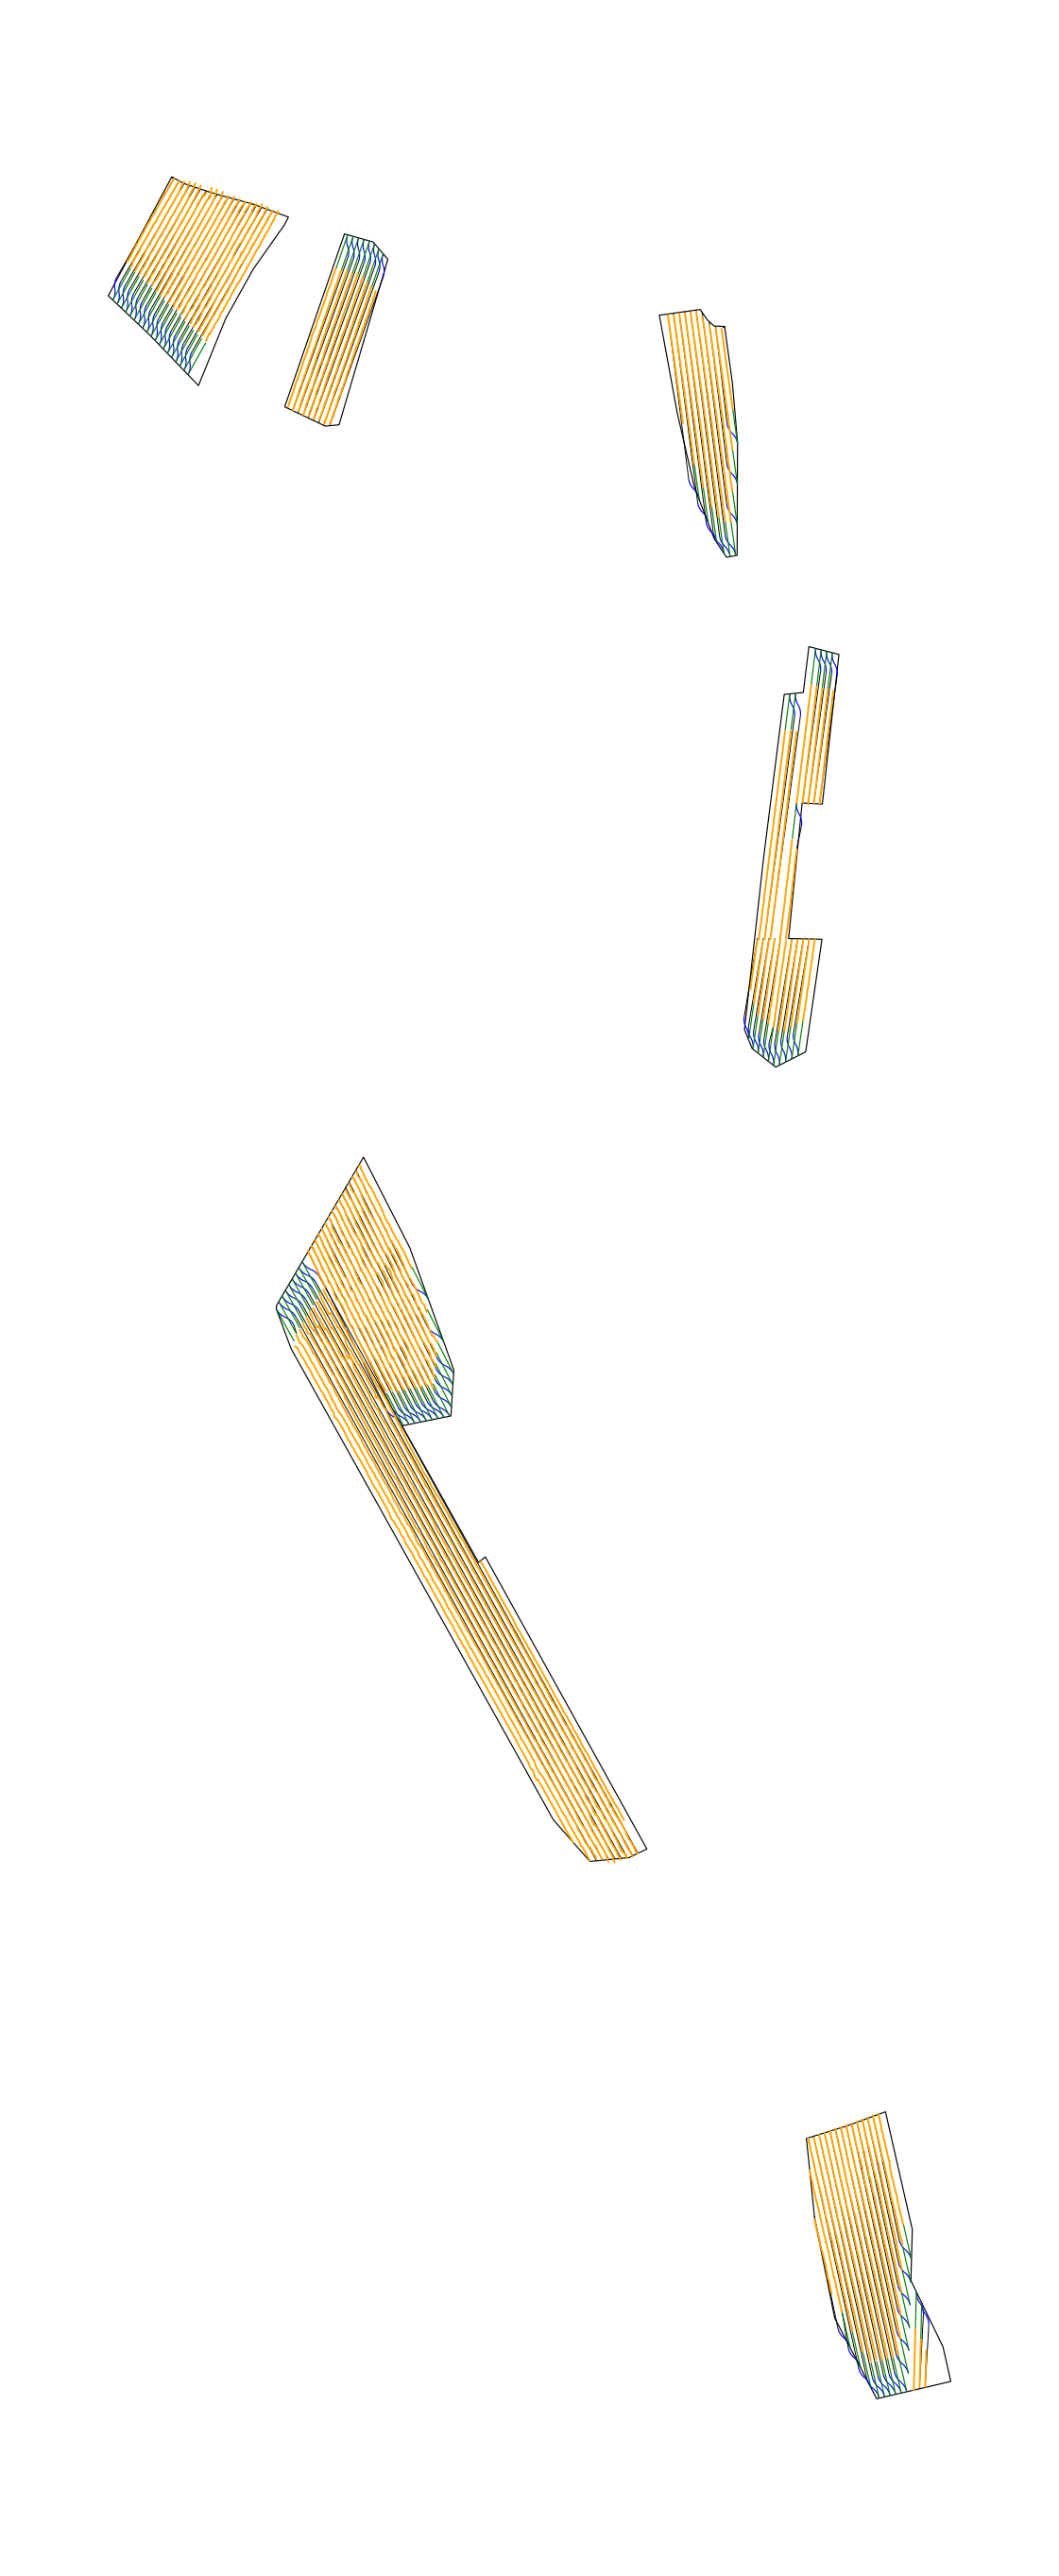

In [7]:
%matplotlib inline
optimal_params = opti_parameters.iloc[opti_parameters['4'].idxmin()]

algor_gen_shp_path = r'../gen_paths/gen_02/gen_01.shp'
algor_gen_shp = gpd.read_file(algor_gen_shp_path)
# 查看所有的路径
_, ax = plt.subplots(dpi=700)
ax.set_axis_off()
ax.set_aspect('equal')
all_land.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=0.12)
# sample_accuracy = 2
sample_accuracy = 0.5
# 制作一个数据表，分别是当前的模拟点，以及模拟点到最近真是路径的距离值
distance_points = []

# 记录所有的采样点
all_point_count = 0

all_distance_data = []
all_straight_distance_data = []
all_simulated_lines = []
# ------------------------------ 绘制转向和地头 ------------------------------
# turning_1.plot(ax=ax, color='b', linewidth=0.12, label='掉头转向')
# backward_moves_1.plot(ax=ax, color='y', linewidth=0.12, label='直线掉头')
# forward_moves_1.plot(ax=ax, color='g', linewidth=0.12, label='直线前进')

turning_all.plot(ax=ax, color='b', linewidth=0.12, label='掉头转向')
backward_moves_all.plot(ax=ax, color='k', linewidth=0.1, label='直线掉头')
forward_moves_all.plot(ax=ax, color='g', linewidth=0.12, label='直线前进')

print('simulation begin')
# ------------------------------ Main Loop ------------------------------
for temp_straight_line in land_all.geometry:
    samples = np.arange(0, temp_straight_line.length, sample_accuracy)
    temp_result_points = []
    temp_distance_data = []
    temp_straight_distance_data = []
    for i, sample in enumerate(samples):
        all_point_count += 1
        # TODO: 找到问题所在
        temp_sample_point = temp_straight_line.interpolate(sample)
        temp_point_data = [
            temp_sample_point.x, temp_sample_point.y,
            get_11_from_raster(temp_sample_point, raster.DEM),
            get_11_from_raster(temp_sample_point, raster.ASPECT),
            get_11_from_raster(temp_sample_point, raster.SLOPE),
            get_11_from_raster(temp_sample_point, raster.CURVATURE)
        ]
        temp_simu_point = model_fit_5(optimal_params[1:], temp_point_data)
        temp_result_points.append(temp_simu_point)
    all_distance_data.append(temp_distance_data)
    all_straight_distance_data.append(temp_straight_distance_data)
    temp_modi_line = LineString(temp_result_points)
    all_simulated_lines.append(temp_modi_line)
    ax.plot(*temp_modi_line.xy, color='orange', linewidth=0.2)
            
print(all_point_count)
    
    
